In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt


In [2]:
# Функция для загрузки изображения и преобразования его в тензор
def load_image(image_path, max_size=400, shape=None):
    image = Image.open(image_path).convert('RGB')

    # Изменение размера изображения
    if max_size:
        size = max(image.size)
        if size > max_size:
            size = max_size
        if shape:
            size = shape
        in_transform = transforms.Compose([
            transforms.Resize(600),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),
                                 (0.229, 0.224, 0.225))])
    else:
        in_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),
                                 (0.229, 0.224, 0.225))])

    # Преобразование изображения в тензор и добавление размерности пакета
    image = in_transform(image)[:3, :, :].unsqueeze(0)

    return image

# Функция для преобразования тензора обратно в изображение
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)
    image = image.clip(0, 1)
    return image


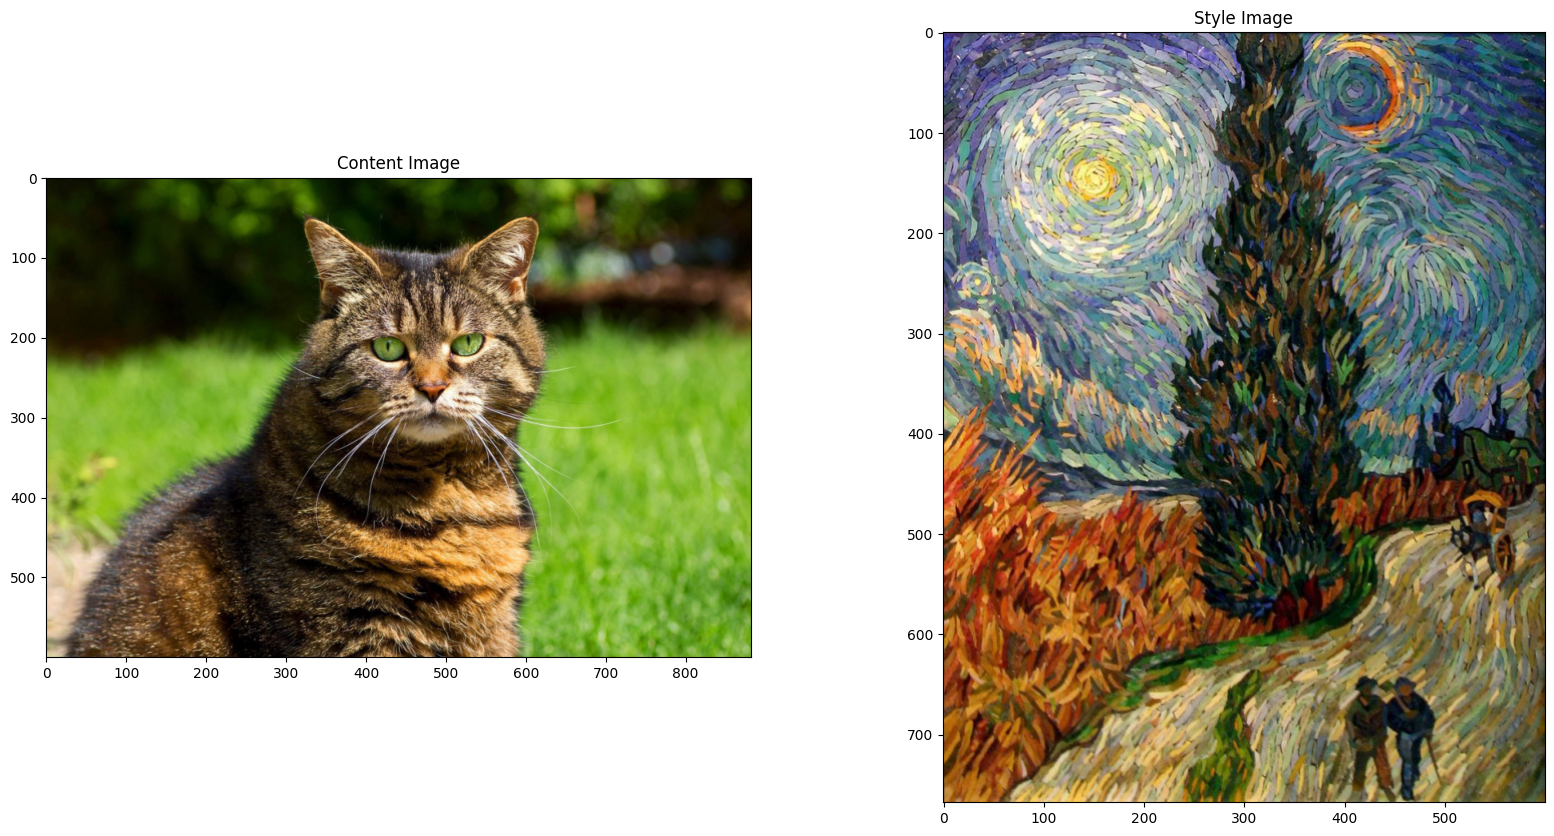

In [12]:
# Load the images
style_image = load_image('/content/22e17198-49b8-475b-9d8d-ff898d474c82.jfif')
content_image = load_image('/content/1638838314_13-koshka-top-p-realnie-kotov-17.jpg', shape=style_image.shape[-2:])

# Display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content_image))
ax1.set_title('Content Image')
ax2.imshow(im_convert(style_image))
ax2.set_title('Style Image')
plt.show()

In [16]:
# Define the VGG model
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.chosen_features = ['0', '5', '10', '19', '28']
        self.model = models.vgg19(pretrained=True).features[:29]

    def forward(self, x):
        features = []
        for layer_num, layer in enumerate(self.model):
            x = layer(x)
            if str(layer_num) in self.chosen_features:
                features.append(x)
        return features

# Define the loss functions
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG().to(device).eval()

# Move images to device
content_image = content_image.to(device)
style_image = style_image.to(device)

# Generate the target image
target = content_image.clone().requires_grad_(True).to(device)

# Define the optimizer
optimizer = optim.Adam([target], lr=0.003)

# Define the style and content weights
style_weight = 1e6
content_weight = 1

# Training loop
for step in range(1000):
    target_features = model(target)
    content_features = model(content_image)
    style_features = model(style_image)

    style_loss = content_loss = 0

    for target_feature, content_feature, style_feature in zip(target_features, content_features, style_features):
        content_loss += torch.mean((target_feature - content_feature) ** 2)

        # Compute the Gram matrix for style features
        target_gram = gram_matrix(target_feature)
        style_gram = gram_matrix(style_feature)
        style_loss += torch.mean((target_gram - style_gram) ** 2)

    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 500 == 0:
        print(f"Step {step}, Total loss: {total_loss.item()}")



Step 0, Total loss: 1.6664116626194432e+16
Step 500, Total loss: 377181544906752.0


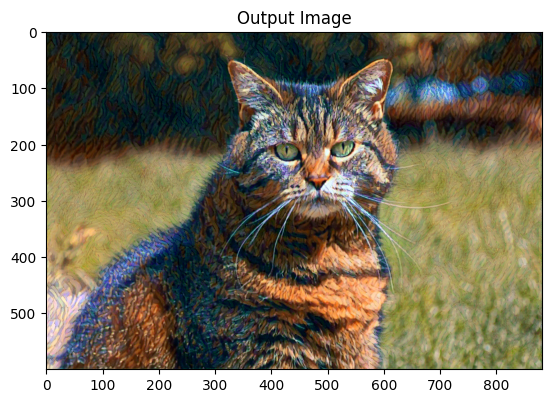

In [17]:
# Отобразить окончательный вывод
final_image = im_convert(target)
plt.imshow(final_image)
plt.title('Output Image')
plt.show()